In [2]:
import r_utils
from dataset import CranberryPatchDataset
from models import (
    PredictionModel, LoraOptions,
    TimeHead, GenotypeHead, YieldHead,
    print_trainable_parameters
)

import torch
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
from tqdm import tqdm
from transformers import AutoImageProcessor
import umap
from sklearn.mixture import BayesianGaussianMixture
from gmr import GMM

Procedure:
1. Seperate dataset into $D_\text{train}$ and $D_\text{test}$ splits.
2. Learn a transformation to latent space ($f_\theta$) from $D_\text{train}$
3. Learn a uMAP transformation ($h_\phi$) from $D_\text{train}$
4. Split the reduced data by genotype
5. Learn a GMM ($g_\gamma$) from a trajectory dataset derived from $D_\text{train}$
6. Show that if you put the test split through this pipeline, you can accurately predict the end points of trajectories


### 1. and 2.
Load the split dataset and the fine tuned model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PredictionModel(
    backbone_name='facebook/dinov2-with-registers-base',
    prediction_heads = [],
    lora_options=None,
    do_normalization=True
).to(device)

# model.load('./checkpoints/geno_drop_test/facebook_dinov2-with-registers-base_time_genotype_8_epochs_10h59m.pth')
# model.load('./checkpoints/geno_drop_test/facebook_dinov2-base_time_genotype_8_epochs_23h39m.pth')

checkpoint_name = './checkpoints_pw/d2-4.pth'

model.load(checkpoint_name)

processor = AutoImageProcessor.from_pretrained(
    model.backbone_name,
    do_rescale=False,
    do_resize=False,
    use_fast=False
)

assert hasattr(model, 'dataset_split_descriptor'), "Start using models with the dataset split saved pls thx"

bog_2_patch_df = torch.load('prepped_data/bog_2_patches_p224_size_1344x2016.pt', weights_only=False)
dataset_locations = r_utils.load_toml('./dataset_locations.toml')
dataset = CranberryPatchDataset(bog_2_patch_df, dataset_locations)

splits = model.dataset_split_descriptor.split(dataset)

# this is the dataset split that was used to learn the latent space
train_dataset = splits['train_dataset']
train_idxs = splits['train_idxs']

val_dataset = splits['test_dataset']
val_idxs = splits['test_idxs']

# the train dataset is unnecessarily large for uMAP and GMM,
# so take another subset of it
np.random.seed(1)
train_subset_indices = np.random.choice(len(train_dataset), 6_000, replace=False)
train_subset = Subset(train_dataset, train_subset_indices)
train_subset_idxs = np.array(train_idxs)[train_subset_indices]

train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=4)

print(f'{len(train_dataset)=}')
print(f'{len(train_subset)=}')

Loading from ./checkpoints_pw/d2-4.pth
Splitting dataset by patch coordinates
Attempting to split the dataset with a 0.8/0.2 split. Actual split: 0.8/0.2.
len(train_dataset)=24312
len(train_subset)=6000


### 3.

In [4]:
@torch.no_grad()
def run_inference(model, processor, dataloader):
    model.eval()
    device = next(model.parameters()).device
    all_outputs = []

    print(f"Running inference on {device}")
    for patch, _ in tqdm(dataloader):
        if processor is not None:
            inputs = processor(patch, return_tensors='pt').to(device)
        else:
            inputs = {'pixel_values': patch.to(device)}
            
        outputs = model(inputs)['latent']
        all_outputs.append(outputs.cpu())

    return torch.cat(all_outputs, dim=0)

train_features = run_inference(model, processor, train_dataloader)
print(f'{train_features.shape=}')
train_subset_features = train_features[train_subset_indices]

val_features = run_inference(model, processor, val_dataloader)

Running inference on cuda:0


100%|██████████| 760/760 [01:33<00:00,  8.17it/s]


train_features.shape=torch.Size([24312, 192])
Running inference on cuda:0


100%|██████████| 187/187 [00:22<00:00,  8.49it/s]


In [5]:
reducer = umap.UMAP(
    n_components=2,
    min_dist=0.05,
    n_neighbors=6
)
train_embedding = reducer.fit_transform(train_features)

train_subset_embedding = train_embedding[train_subset_indices]

val_embedding = reducer.transform(val_features)

In [ ]:
print(reducer)

0.05


In [81]:
train_subset_features = train_features[train_subset_indices]
train_subset_embedding = train_embedding[train_subset_indices]

### 4.

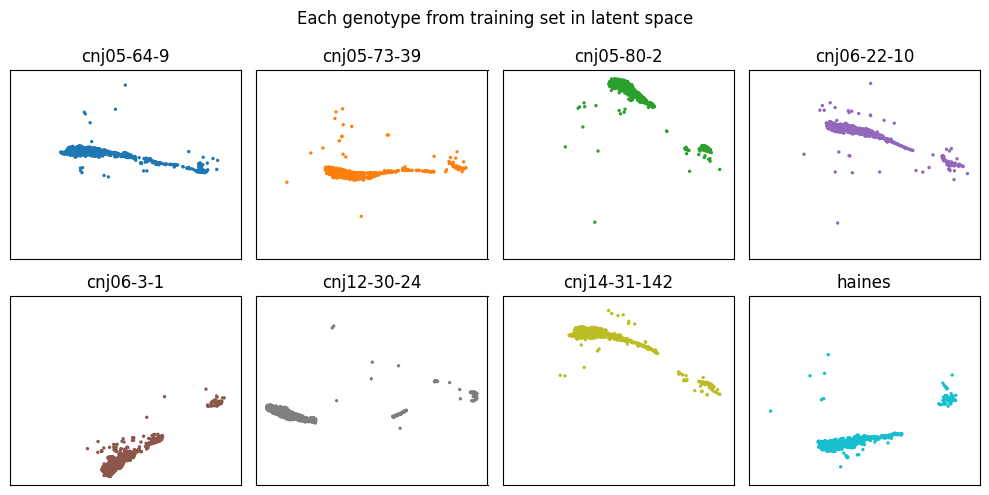

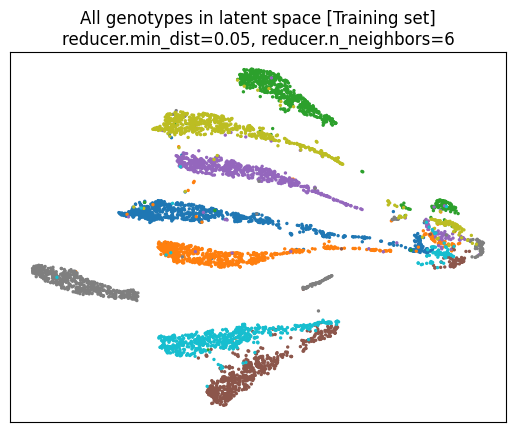

In [7]:
relevant_rows = bog_2_patch_df.iloc[train_subset_idxs]
categories = relevant_rows['plot'].astype('category').cat
plot_codes = categories.codes
plot_names = categories.categories
plot_c, _ = r_utils.values_to_colors(list(plot_codes), cmap_name='tab10')

# split up the dataset according to genotype
genotype_splits = []
for i in range(dataset.num_genotypes):
    genotype_splits.append(np.flatnonzero(plot_codes == i))


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

for ax, split in zip(axs, genotype_splits):
    ax.scatter(*train_subset_embedding[split].T, s=2, c=np.array(plot_c)[split])

for name, ax in zip(plot_names, axs):
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Each genotype from training set in latent space")
plt.tight_layout()
plt.show()

plt.figure()
for split in genotype_splits:
    plt.scatter(*train_subset_embedding[split].T, s=2, c=np.array(plot_c)[split])
plt.xticks([])
plt.yticks([])
plt.title(f'All genotypes in latent space [Training set]\n{reducer.min_dist=}, {reducer.n_neighbors=}')
plt.show()

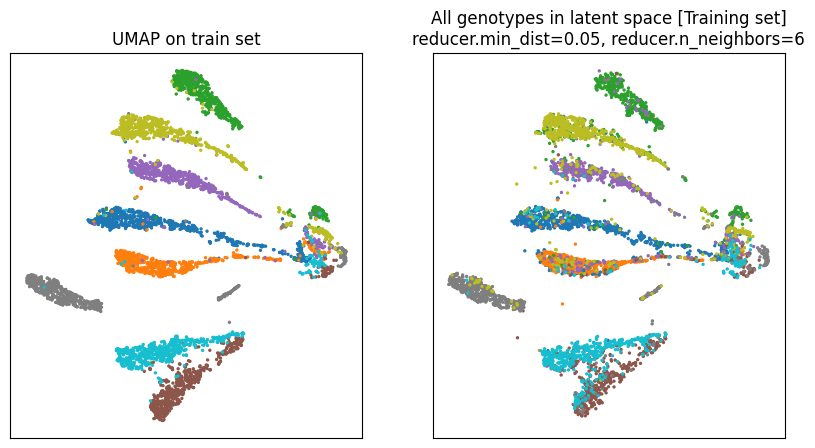

In [11]:
train_subset_rows = bog_2_patch_df.iloc[train_subset_idxs]
val_rows = bog_2_patch_df.iloc[val_idxs]

train_categories = train_subset_rows['plot'].astype('category').cat
train_plot_codes = train_categories.codes
train_plot_names = train_categories.categories
train_plot_c, _ = r_utils.values_to_colors(list(train_plot_codes), cmap_name='tab10')

val_categories = val_rows['plot'].astype('category').cat
val_plot_codes = val_categories.codes
val_plot_names = val_categories.categories
val_plot_c, _ = r_utils.values_to_colors(list(val_plot_codes), cmap_name='tab10')

# split up the dataset according to genotype
train_genotype_splits = []
for i in range(dataset.num_genotypes):
    train_genotype_splits.append(np.flatnonzero(train_plot_codes == i))

val_genotype_splits = []
for i in range(dataset.num_genotypes):
    val_genotype_splits.append(np.flatnonzero(val_plot_codes == i))


fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

# for ax, split in zip(axs, genotype_splits):
    # ax.scatter(*train_subset_embedding[split].T, s=2, c=np.array(plot_c)[split])

axs[0].set_title("UMAP on train set")
for split in train_genotype_splits:
    axs[0].scatter(*train_subset_embedding[split].T, s=2, c=np.array(train_plot_c)[split])


axs[1].set_title("UMAP on test set")
for split in val_genotype_splits:
    axs[1].scatter(*val_embedding[split].T, s=2, c=np.array(val_plot_c)[split])
# for name, ax in zip(plot_names, axs):
#     ax.set_title(name)
#     ax.set_xticks([])
#     ax.set_yticks([])

# plt.suptitle("Each genotype from training set in latent space")
# plt.tight_layout()
# plt.show()

# plt.figure()

plt.xticks([])
plt.yticks([])
plt.title(f'All genotypes in latent space [Training set]\n{reducer.min_dist=}, {reducer.n_neighbors=}')
plt.show()

### 5.

In [13]:
def fit_gmm(embedding, df_rows, random_state=0, n_components=20, date_gap=3):
    '''
    Fits a gaussian mixture model trajectory datapoints sampled from the provided points.
    See 'Sample time-invariant trajectories' example here: https://github.com/AlexanderFabisch/gmr

    Args:
        date_gap: velocity is calculated between two dates. date gap is the number of days
            between those two dates. a higher value will smooth out velocity more.
    '''
    date_codes = df_rows['date'].astype('category').cat.codes

    # split up according to date
    date_splits = []
    for i in range(dataset.num_dates):
        date_splits.append(np.flatnonzero(date_codes==i))
    
    idx_pairs = []
    for i in range(len(date_splits) - date_gap):
        idx_pairs.extend(itertools.product(date_splits[i], date_splits[i+date_gap]))

    idx_pairs = np.array(idx_pairs)

    # stack position and velocity
    X_train = np.hstack((
        embedding[idx_pairs[:, 0]],
        embedding[idx_pairs[:, 1]] - embedding[idx_pairs[:, 0]]
    ))

    random_state = np.random.RandomState(random_state)
    n_components = n_components

    bgmm = BayesianGaussianMixture(
        n_components=n_components,
        max_iter=1000,
        random_state=random_state
    ).fit(X_train)

    gmm = GMM(
        n_components=n_components,
        priors=bgmm.weights_,
        means=bgmm.means_,
        covariances=bgmm.covariances_,
        random_state=random_state
    )

    return gmm


def sample_path(start, gmm, dt=0.05, max_time=40, alpha=0.9):
    path = []
    x = start
    for i in range(int(max_time/dt)):
        path.append(x)
        cgmm = gmm.condition([0, 1], x)
        # alpha defines the confidence region (e.g., 0.7 -> 70 %)
        x_dot = cgmm.sample_confidence_region(1, alpha=alpha)[0]
        x = x + dt * x_dot
    return np.array(path)

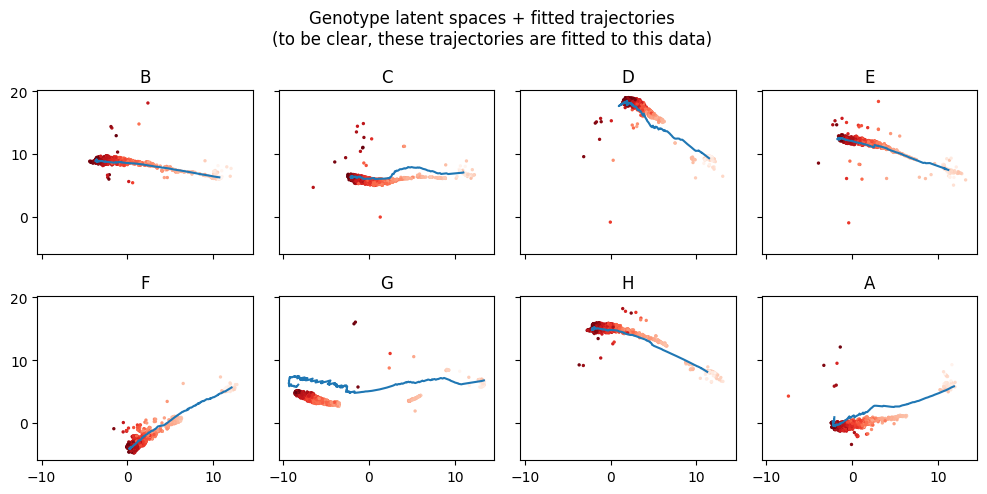

In [ ]:
genotype_gmms = []
sampled_paths = []



fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5), sharex=True, sharey=True)
axs = axs.flatten()

for genotype_index in range(len(train_genotype_splits)):
    geno_split = train_genotype_splits[genotype_index]
    gmm = fit_gmm(
        train_subset_embedding[geno_split],
        train_subset_rows.iloc[geno_split],
        date_gap=12
    )

    start_idx = np.flatnonzero(train_subset_rows.iloc[geno_split]['date'] == dataset.first_date)[0]
    sampled_path = sample_path(train_subset_embedding[geno_split][start_idx], gmm, alpha=0.99, max_time=10, dt=0.03)
    date_c, _ = r_utils.values_to_colors(list(train_subset_rows.iloc[geno_split]['date'].astype('category').cat.codes), cmap_name='Reds')
    sampled_paths.append(sampled_path)

    axs[genotype_index].plot(sampled_path[:, 0], sampled_path[:, 1])
    axs[genotype_index].scatter(*train_subset_embedding[geno_split].T, s=2, c=date_c)
    axs[genotype_index].set_title(r_utils.var_to_letter[plot_names[genotype_index]])

    genotype_gmms.append(gmm)

plt.suptitle("Genotype latent spaces + fitted trajectories\n(to be clear, these trajectories are fitted to this data)")
plt.tight_layout()
plt.show()


In [1]:
for ax, split in zip(axs, genotype_splits):
    ax.scatter(*train_subset_embedding[split].T, s=2, c=np.array(plot_c)[split])

NameError: name 'axs' is not defined

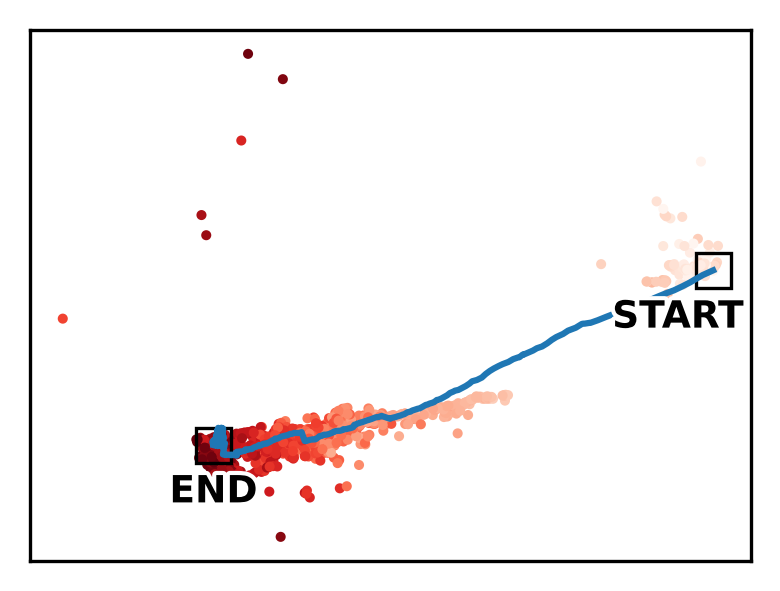

In [ ]:
import matplotlib.patheffects as path_effects

fig_scale=0.4
fig_size = (7.75, 5.75)

wh_ratio = fig_size[0] / fig_size[1]
plt.figure(figsize=(fig_scale*fig_size[0],fig_scale*fig_size[1]), dpi=300)
ax = plt.gca()

i = 7
end = 150
geno_split = genotype_splits[i]
date_c, _ = values_to_colors(list(relevant_rows.iloc[geno_split]['date'].astype('category').cat.codes), cmap_name='Reds')

plt.xticks([])
plt.yticks([])
plt.plot(sampled_paths[i][:-end, 0], sampled_paths[i][:-end, 1])
plt.scatter(*train_subset_embedding[geno_split].T, s=2, c=date_c)


start_sq = sampled_paths[i][0]
end_sq = sampled_paths[i][-end-1]

x_ext = plt.xlim()[1] - plt.xlim()[0]
y_ext = plt.ylim()[1] - plt.ylim()[0]

hw_ratio = x_ext / y_ext

sq_w = 1.0
sq_h = sq_w / hw_ratio * fig_size[0] / fig_size[1]

square = plt.Rectangle((start_sq[0]-0.5*sq_w, start_sq[1]-0.5*sq_h), sq_w, sq_h, edgecolor='black', facecolor='none', linewidth=0.8)
ax.add_patch(square)
ax.text(
    start_sq[0]-1, start_sq[1]-sq_h/2-0.4, 
    # start_sq[0]-2.7, start_sq[1]+0.4,
    'START', ha='center', va='top', fontsize=9,
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ]
)

square = plt.Rectangle((end_sq[0]-0.5*sq_w, end_sq[1]-0.5*sq_h), sq_w, sq_h, edgecolor='black', facecolor='none', linewidth=0.8)
ax.add_patch(square)
ax.text(
    end_sq[0], end_sq[1]-sq_h/2-0.4,
    # end_sq[0]-2, end_sq[1]+0.4,
    'END', ha='center', va='top', fontsize=9,
    weight='bold',
    path_effects=[
        path_effects.Stroke(linewidth=2, foreground='white'),
        path_effects.Normal()
    ]
)

# plt.savefig(f"../media/per_geno_traj_{i}.png", bbox_inches='tight',pad_inches=0.02)

